#### Variational AutoEncoders

* Probabilistic Autoencoders
* Encoder takes an input and produces a learned mean **Z_mu** and a learned variance **Z_sigma** 
  * The mean and variance generated define a Normal distrbution 
  * The Final Encoding is then **Sampled** from this learnt **Normal Distribution**
* The decoder takes the sampled encoding and outputs a resembeling output to the input 

In [9]:
from tensorflow import keras
from keras.models import Model
from keras import Input
from keras.layers import Dense, Lambda
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from keras import backend as K
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import graphviz
import plotly
import plotly.express as px

In [7]:
# Data Processing :

(X_train , Y_train ), (X_test , Y_test) = keras.datasets.fashion_mnist.load_data()

In [3]:
# Print shapes
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", Y_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", Y_test.shape)

Shape of X_train:  (60000, 28, 28)
Shape of y_train:  (60000,)
Shape of X_test:  (10000, 28, 28)
Shape of y_test:  (10000,)


In [4]:
# Normalization :
X_train = X_train.astype("float32")/255
X_test = X_test.astype("float32")/255

In [10]:
# Reshape images to a flat vector
x_train = np.reshape(X_train, (len(X_train), 784))
x_test = np.reshape(X_test, (len(X_test), 784))

# Convert data to TensorFlow dataset
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(len(x_train)).batch(128)
test_dataset = tf.data.Dataset.from_tensor_slices(x_test).batch(128)

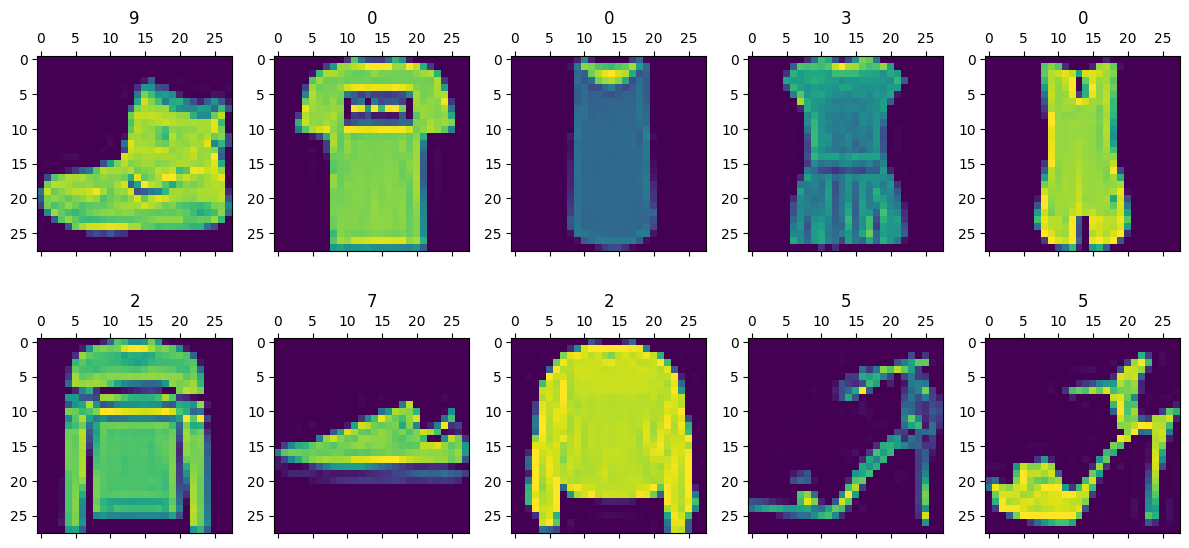

In [12]:
# Display images of the first images in the training set and their true lables
fig, axs = plt.subplots(2, 5, sharey=False, tight_layout=True, figsize=(12,6), facecolor='white')
n=0
for i in range(0,2):
    for j in range(0,5):
        axs[i,j].matshow(X_train[n])
        axs[i,j].set(title=Y_train[n])
        n=n+1
plt.show() 

In [13]:
# Define sampling function
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Define VAE Model
latent_dim = 2

# Define encoder model
encoder_inputs = tf.keras.Input(shape=(784,))
x = tf.keras.layers.Dense(256, activation='relu')(encoder_inputs)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
z_mean = tf.keras.layers.Dense(latent_dim)(x)
z_log_var = tf.keras.layers.Dense(latent_dim)(x)


z = tf.keras.layers.Lambda(sampling)([z_mean, z_log_var])

# Define decoder model
decoder_inputs = tf.keras.layers.Input(shape=(latent_dim,))
x = tf.keras.layers.Dense(64, activation='relu')(decoder_inputs)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
decoder_outputs = tf.keras.layers.Dense(784, activation='sigmoid')(x)

# Define VAE model
encoder = tf.keras.Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')
decoder = tf.keras.Model(decoder_inputs, decoder_outputs, name='decoder')
vae_outputs = decoder(encoder(encoder_inputs)[2])
vae = tf.keras.Model(encoder_inputs, vae_outputs, name='vae')


In [14]:
# Define Loss and Optimizer 
def vae_loss(x, x_recon, z_mean, z_log_var):
    recon_loss = tf.reduce_sum(tf.keras.losses.binary_crossentropy(x, x_recon), axis=-1)
    kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
    return tf.reduce_mean(recon_loss + kl_loss)

optimizer = tf.keras.optimizers.Adam()



In [15]:
# Training Loop
"""
def train_step(x):
    with tf.GradientTape() as tape:
        z_mean, z_log_var, z = encoder(x)
        x_recon = decoder(z)
        recon_loss = tf.reduce_sum(tf.keras.losses.binary_crossentropy(x, x_recon), axis=-1)
        kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
        total_loss = tf.reduce_mean(recon_loss + kl_loss)
    gradients = tape.gradient(total_loss, vae.trainable_variables)
    optimizer.apply_gradients(zip(gradients, vae.trainable_variables))
    return recon_loss, kl_loss

epochs = 50

for epoch in range(epochs):
    print('Epoch', epoch+1)
    for step, x in enumerate(train_dataset):
        recon_loss, kl_loss = train_step(x)
        if step % 100 == 0:
            print('Step', step, 'Recon Loss', tf.reduce_mean(recon_loss).numpy(), 'KL Loss', tf.reduce_mean(kl_loss).numpy())

"""

Epoch 1


Step 0 Recon Loss nan KL Loss inf
Step 100 Recon Loss nan KL Loss nan
Step 200 Recon Loss nan KL Loss nan
Step 300 Recon Loss nan KL Loss nan
Step 400 Recon Loss nan KL Loss nan
Epoch 2
Step 0 Recon Loss nan KL Loss nan
Step 100 Recon Loss nan KL Loss nan
Step 200 Recon Loss nan KL Loss nan
Step 300 Recon Loss nan KL Loss nan
Step 400 Recon Loss nan KL Loss nan
Epoch 3
Step 0 Recon Loss nan KL Loss nan
Step 100 Recon Loss nan KL Loss nan
Step 200 Recon Loss nan KL Loss nan
Step 300 Recon Loss nan KL Loss nan
Step 400 Recon Loss nan KL Loss nan
Epoch 4
Step 0 Recon Loss nan KL Loss nan
Step 100 Recon Loss nan KL Loss nan
Step 200 Recon Loss nan KL Loss nan
Step 300 Recon Loss nan KL Loss nan
Step 400 Recon Loss nan KL Loss nan
Epoch 5
Step 0 Recon Loss nan KL Loss nan
Step 100 Recon Loss nan KL Loss nan


KeyboardInterrupt: ignored

In [ ]:
#  Generate New Images
n = 15  # Number of images to generate
size = 28  # Size of each image

# Sample points in the latent space
z_sample = tf.random.normal(shape=(n, latent_dim))

# Generate images from the sampled points
x_recon = decoder(z_sample)

# Reshape the images to their original shape
x_recon = np.reshape(x_recon.numpy(), (n, size, size))

# Display the generated images
plt.figure(figsize=(10, 10))
for i in range(n):
    plt.subplot(5, 5, i+1)
    plt.imshow(x_recon[i], cmap='gray')
    plt.axis('off')
plt.show()
